# Inverse scattering for circular billiard

## Importação das bibliotecas

In [111]:
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import utils.Utils as utils
import utils.GenerateData as generateData
import model.GeneralizedMLP as gMLP

## Lendo os dados

In [112]:
df = pd.read_csv('./data/dados_reduzidos.csv')

In [113]:
df

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k21,l_k22,l_k23,l_k24,l_k25,l_k26,l_k27,l_k28,l_k29,l_k30
0,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,0.1,0.100000,0.155397,...,0.001695,0.001611,0.001535,0.001464,0.001399,0.001339,0.001283,0.001231,0.001182,0.001136
1,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,0.1,0.110053,0.184685,...,0.002030,0.001928,0.001835,0.001749,0.001670,0.001597,0.001529,0.001465,0.001406,0.001350
2,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,0.1,0.120106,0.215951,...,0.002390,0.002268,0.002157,0.002054,0.001959,0.001871,0.001790,0.001713,0.001642,0.001575
3,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,0.1,0.130159,0.249095,...,0.002772,0.002629,0.002498,0.002377,0.002265,0.002161,0.002064,0.001973,0.001889,0.001809
4,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,0.1,0.140212,0.284026,...,0.003176,0.003009,0.002856,0.002715,0.002584,0.002462,0.002349,0.002243,0.002144,0.002051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55095,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,3.0,1.959788,34.509730,...,8.950060,9.284191,9.829734,10.822273,8.461594,8.755567,8.121607,8.656062,9.314331,9.423622
55096,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,3.0,1.969841,34.602123,...,9.030403,9.375858,9.968033,10.866505,8.518144,8.710718,8.225802,8.789683,9.473082,9.218014
55097,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,3.0,1.979894,34.694353,...,9.110803,9.469669,10.115635,10.766648,8.617675,8.615138,8.340512,8.925552,9.631447,8.946899
55098,1.0,1.0,0.02,3.02,0.1,-20.0,20.0,3.0,1.989947,34.786420,...,9.191401,9.565972,10.273826,10.486231,8.741581,8.503074,8.461178,9.064258,9.783225,8.681035


## Implementação da rede neural

### Definição dos inputs da rede

In [114]:
features = df.drop(columns=['R'])

features = features.to_numpy()

In [115]:
targets = df[['R']]

targets = targets.to_numpy()

In [116]:
print(features.shape)
print(targets.shape)

(55100, 38)
(55100, 1)


### Definição da rede neural

A rede neural implementada é uma rede neural do tipo Multilayer Perceptron

### Variáveis para o modelo, separação dos dados de teste e treino e etc

In [117]:
train, test_data = train_test_split(features, test_size = 0.2, random_state = 2)
real_train_data, validation_data = train_test_split(train, test_size = 0.3, random_state = 2)

train_target, test_target = train_test_split(targets, test_size = 0.2, random_state = 2)
real_train_target, validation_target = train_test_split(train_target, test_size = 0.3, random_state = 2)

input_size = 38
output_size = 1
batch_size = 256
num_epochs = 1000
learning_rate = 0.0001

In [118]:
train_loader, val_loader, test_loader = utils.prepare_data(real_train_data, real_train_target, test_data, test_target, validation_data, validation_target, batch_size)

Input Shapes:
torch.Size([30856, 38]) torch.Size([13224, 38]) torch.Size([11020, 38])
Target Shapes:
torch.Size([30856, 1]) torch.Size([13224, 1]) torch.Size([11020, 1])


### Primeira rodada de treinamento

In [119]:
# nums_neurons = [20, 40, 60, 80, 100, 140, 180, 220, 260, 300, 340, 380, 420]
running_loss_total_arrays = []
val_loss_total_arrays = []
test_loss_total = []

# for num in nums_neurons:
    
model = gMLP.GeneralizedMLP(input_size, output_size, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(model.state_dict(), 'mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 0.5276097023536351, Validation Loss: 0.2428777002944396
Epoch 2/1000, Training Loss: 0.15220138350547838, Validation Loss: 0.1231884784423388
Epoch 3/1000, Training Loss: 0.11495022297151818, Validation Loss: 0.11053216858552052
Epoch 4/1000, Training Loss: 0.1032499668519359, Validation Loss: 0.10000124172522472
Epoch 5/1000, Training Loss: 0.0929687151238938, Validation Loss: 0.0900412886761702
Epoch 6/1000, Training Loss: 0.08317288633220452, Validation Loss: 0.08077845271103658
Epoch 7/1000, Training Loss: 0.07423099967812703, Validation Loss: 0.07231067443409792
Epoch 8/1000, Training Loss: 0.06618581382819444, Validation Loss: 0.0648117674371371
Epoch 9/1000, Training Loss: 0.059155077542647844, Validation Loss: 0.05834155099896284
Epoch 10/1000, Training Loss: 0.05306637068548478, Validation Loss: 0.05272029598171894
Epoch 11/1000, Training Loss: 0.04776929243475445, Validation Loss: 0.048153090792206615
Epoch 12/1000, Training Lo

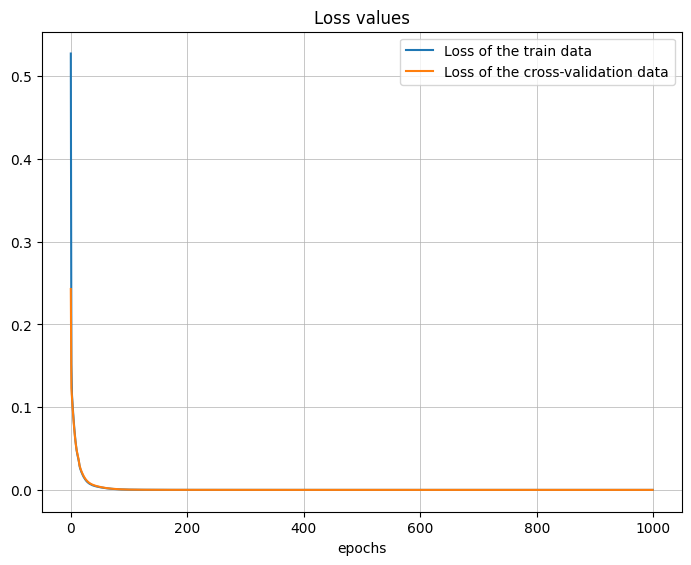

In [120]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[0]
list_val = val_loss_total_arrays[0]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Segunda rodada de treinamento

In [121]:
saved_state_dict = torch.load('mlp_weights.pth')

# Initialize the new model
extended_model = gMLP.GeneralizedMLP(input_size, output_size, 2)

# Copy the weights of the hidden_layer to hidden_layer1

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 0.7867397365491252, Validation Loss: 0.5914937601639674
Epoch 2/1000, Training Loss: 0.4629940058081603, Validation Loss: 0.37602899510126847
Epoch 3/1000, Training Loss: 0.32403965158896014, Validation Loss: 0.28732680013546574
Epoch 4/1000, Training Loss: 0.2613554672022496, Validation Loss: 0.23967115896252486
Epoch 5/1000, Training Loss: 0.22133142655053414, Validation Loss: 0.2044335168141585
Epoch 6/1000, Training Loss: 0.18914530481681352, Validation Loss: 0.17418976013477033
Epoch 7/1000, Training Loss: 0.1581875436808452, Validation Loss: 0.14200550303436243
Epoch 8/1000, Training Loss: 0.12559662999446727, Validation Loss: 0.11104854181982003
Epoch 9/1000, Training Loss: 0.09576872280560249, Validation Loss: 0.08388810819731309
Epoch 10/1000, Training Loss: 0.07252516520540576, Validation Loss: 0.0643594589514228
Epoch 11/1000, Training Loss: 0.055655725608187274, Validation Loss: 0.050713738068365134
Epoch 12/1000, Training Lo

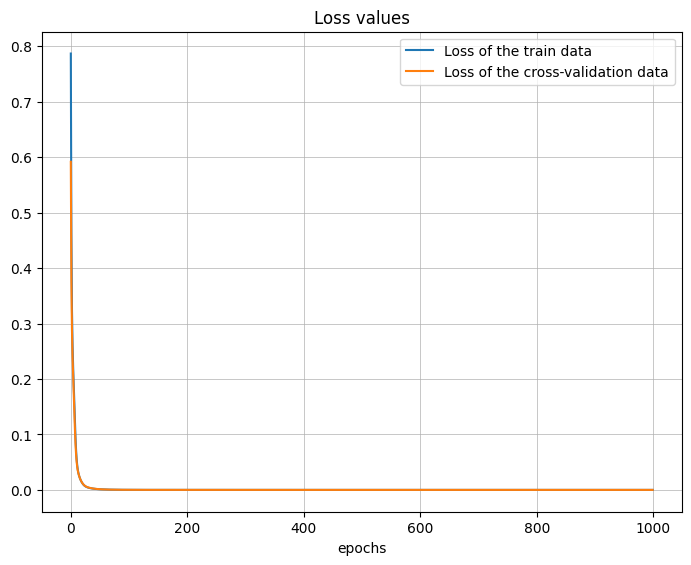

In [122]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[1]
list_val = val_loss_total_arrays[1]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Terceira rodada de treinamento

In [123]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 3)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 2):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})

criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')


hidden neurons:  26
Epoch 1/1000, Training Loss: 1.2470196308183277, Validation Loss: 0.9798703583387228
Epoch 2/1000, Training Loss: 0.7704862784748235, Validation Loss: 0.608074250129553
Epoch 3/1000, Training Loss: 0.49404969097168977, Validation Loss: 0.4089002041862561
Epoch 4/1000, Training Loss: 0.34754976186870545, Validation Loss: 0.3000858678267552
Epoch 5/1000, Training Loss: 0.2642059866800781, Validation Loss: 0.23652559203597215
Epoch 6/1000, Training Loss: 0.21552809247793245, Validation Loss: 0.19808699992986825
Epoch 7/1000, Training Loss: 0.18371509446585474, Validation Loss: 0.1705966780965145
Epoch 8/1000, Training Loss: 0.15867403525212578, Validation Loss: 0.14706792080631623
Epoch 9/1000, Training Loss: 0.135972702059864, Validation Loss: 0.12498355040756556
Epoch 10/1000, Training Loss: 0.11484468075608419, Validation Loss: 0.10482656998703113
Epoch 11/1000, Training Loss: 0.09544744182470416, Validation Loss: 0.08653023480795898
Epoch 12/1000, Training Loss: 0.

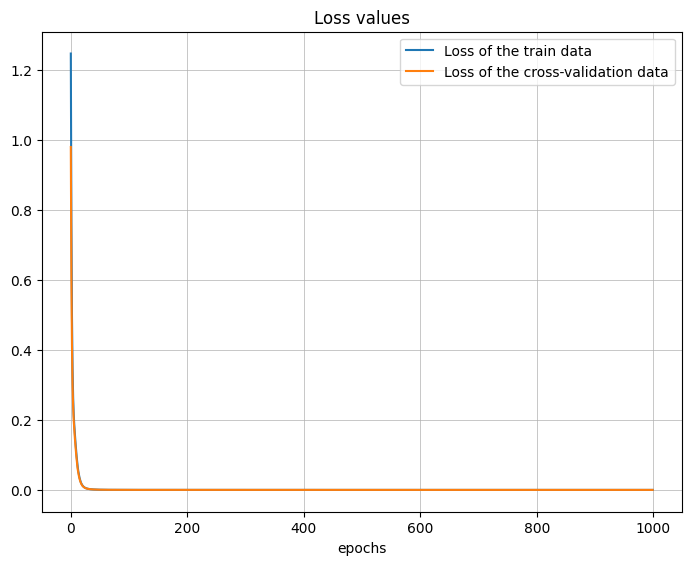

In [124]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[2]
list_val = val_loss_total_arrays[2]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

#### Quarta rodada de treinamento

In [125]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 4)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 3):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 0.8973397986947997, Validation Loss: 0.6983871918458205
Epoch 2/1000, Training Loss: 0.5525184079142641, Validation Loss: 0.4419539009149258
Epoch 3/1000, Training Loss: 0.36753335545870885, Validation Loss: 0.3125458279481301
Epoch 4/1000, Training Loss: 0.27486517434277813, Validation Loss: 0.245518787835653
Epoch 5/1000, Training Loss: 0.22310127293275409, Validation Loss: 0.20329675622857535
Epoch 6/1000, Training Loss: 0.1863247523130464, Validation Loss: 0.16983807631410086
Epoch 7/1000, Training Loss: 0.15530680421709028, Validation Loss: 0.14058278687298298
Epoch 8/1000, Training Loss: 0.12779117369454754, Validation Loss: 0.11479324088073693
Epoch 9/1000, Training Loss: 0.10379950228062543, Validation Loss: 0.09262932507464519
Epoch 10/1000, Training Loss: 0.08344196497408812, Validation Loss: 0.07403455409579553
Epoch 11/1000, Training Loss: 0.06623191515768855, Validation Loss: 0.05851876291518028
Epoch 12/1000, Training Loss:

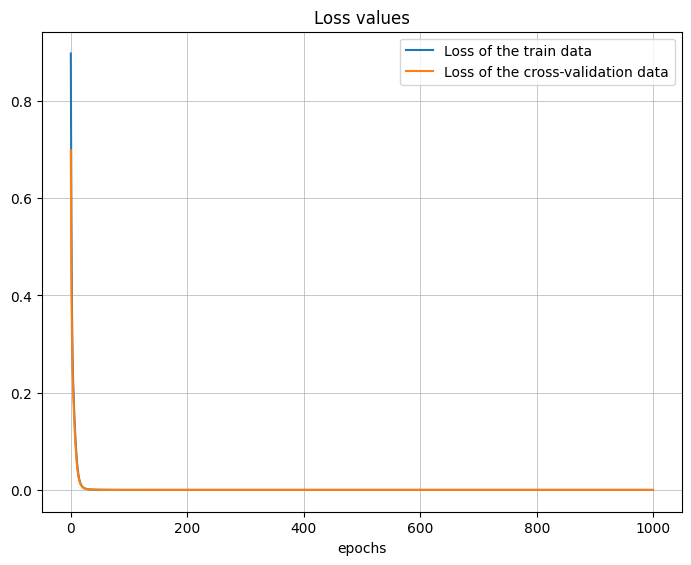

In [126]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[3]
list_val = val_loss_total_arrays[3]

axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

### Quinta rodada

In [127]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 5)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 4):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 1.2407155086186306, Validation Loss: 0.9983140837687713
Epoch 2/1000, Training Loss: 0.8042228832717769, Validation Loss: 0.6504746503554858
Epoch 3/1000, Training Loss: 0.5333715063973892, Validation Loss: 0.4428039175959734
Epoch 4/1000, Training Loss: 0.3738844096660614, Validation Loss: 0.32110169472602695
Epoch 5/1000, Training Loss: 0.2812295693996524, Validation Loss: 0.2508373928184693
Epoch 6/1000, Training Loss: 0.22732731330493264, Validation Loss: 0.20847191059818634
Epoch 7/1000, Training Loss: 0.19321522744726544, Validation Loss: 0.1798193185375287
Epoch 8/1000, Training Loss: 0.16874762261209408, Validation Loss: 0.1577856778525389
Epoch 9/1000, Training Loss: 0.14870067451857338, Validation Loss: 0.13935829756351617
Epoch 10/1000, Training Loss: 0.1318051041650378, Validation Loss: 0.1235441999653211
Epoch 11/1000, Training Loss: 0.11678948216448146, Validation Loss: 0.10930415558127257
Epoch 12/1000, Training Loss: 0.10

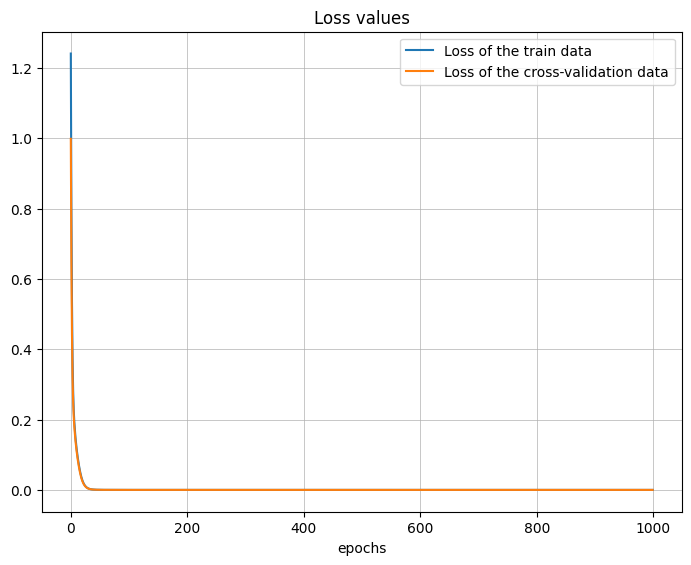

In [128]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[4]
list_val = val_loss_total_arrays[4]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

#### Sexta rodada

In [129]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 6)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 5):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
running_loss_array, val_loss_array = gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)

running_loss_total_arrays.append(running_loss_array)
val_loss_total_arrays.append(val_loss_array)
outputs, test_loss = gMLP.evaluate_model(extended_model, criterion, test_loader)
test_loss_total.append(test_loss)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 2.792695285860172, Validation Loss: 2.3336868790479808
Epoch 2/1000, Training Loss: 1.9421950430909465, Validation Loss: 1.613352901660479
Epoch 3/1000, Training Loss: 1.3333784928006573, Validation Loss: 1.1048460740309496
Epoch 4/1000, Training Loss: 0.9147466706835534, Validation Loss: 0.7637622654438019
Epoch 5/1000, Training Loss: 0.6421858680642341, Validation Loss: 0.5480683107788746
Epoch 6/1000, Training Loss: 0.4719349377411456, Validation Loss: 0.41297609072465163
Epoch 7/1000, Training Loss: 0.3644518701990774, Validation Loss: 0.32850621010248476
Epoch 8/1000, Training Loss: 0.2994612952894416, Validation Loss: 0.27861950202630115
Epoch 9/1000, Training Loss: 0.26109002050289437, Validation Loss: 0.24810995620030624
Epoch 10/1000, Training Loss: 0.23678151179443707, Validation Loss: 0.22817578310003647
Epoch 11/1000, Training Loss: 0.220635640227105, Validation Loss: 0.21396161243319511
Epoch 12/1000, Training Loss: 0.208082

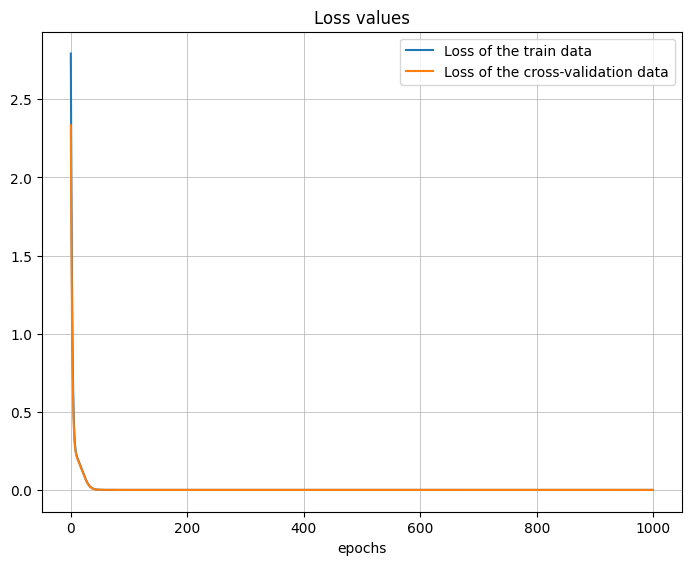

In [130]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
list_train = running_loss_total_arrays[5]
list_val = val_loss_total_arrays[5]


axes.plot(list_train, ls='-', lw=1.5, label='Loss of the train data')
axes.plot(list_val, ls='-', lw=1.5, label='Loss of the cross-validation data')

axes.set_title(f'Loss values')
axes.set_xlabel(f'epochs')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

breakpoint!

In [131]:
# data_list = [
#     [1, 2, 3, ..., 150],  # run_1
#     [4, 5, 6, ..., 150],  # run_2
#     [7, 8, 9, ..., 150],  # run_3
#     [10, 11, 12, ..., 150],  # run_4
#     [13, 14, 15, ..., 150],  # run_5
#     [16, 17, 18, ..., 150],  # run_6
# ]

# Transpondo a lista para obter o formato desejado (6 colunas e 150 linhas)
data_transposed = list(zip(*running_loss_total_arrays))

# Criando o DataFrame
df = pd.DataFrame(data_transposed, columns=[f'run_{i+1}' for i in range(6)])

# Salvando em um arquivo CSV
df.to_csv('dados_train_loss_runs_reduzido.csv', index=False)

print("Arquivo CSV salvo com sucesso.")

Arquivo CSV salvo com sucesso.


In [132]:
# Transpondo a lista para obter o formato desejado (6 colunas e 150 linhas)
data_transposed = list(zip(*val_loss_total_arrays))

# Criando o DataFrame
df = pd.DataFrame(data_transposed, columns=[f'run_{i+1}' for i in range(6)])

# Salvando em um arquivo CSV
df.to_csv('dados_val_loss_runs_reduzido.csv', index=False)

print("Arquivo CSV salvo com sucesso.")

Arquivo CSV salvo com sucesso.


### Sétima rodada

In [9]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 7)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 6):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

hidden neurons:  26
Epoch 1/1000, Training Loss: 2.323694432077329, Validation Loss: 1.963997749181894
Epoch 2/1000, Training Loss: 1.694501997025545, Validation Loss: 1.4257466815985167
Epoch 3/1000, Training Loss: 1.2318948157562697, Validation Loss: 1.0436669633938715
Epoch 4/1000, Training Loss: 0.9158013330018224, Validation Loss: 0.7939728303597524
Epoch 5/1000, Training Loss: 0.7149849218770492, Validation Loss: 0.6408870013860556
Epoch 6/1000, Training Loss: 0.5863215396226931, Validation Loss: 0.5295388251543045
Epoch 7/1000, Training Loss: 0.4932046076975578, Validation Loss: 0.4559656438919214
Epoch 8/1000, Training Loss: 0.4294625124162879, Validation Loss: 0.40125295577140957
Epoch 9/1000, Training Loss: 0.3805012365510641, Validation Loss: 0.358296024111601
Epoch 10/1000, Training Loss: 0.34147521311586554, Validation Loss: 0.3233121891434376
Epoch 11/1000, Training Loss: 0.30969259906406243, Validation Loss: 0.29466791909474593
Epoch 12/1000, Training Loss: 0.28299852171

### Oitava rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 8)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 7):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

#### Nona rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 9)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 8):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Décima rodada

In [ ]:
saved_state_dict = torch.load('generalized_mlp_weights.pth')

extended_model = gMLP.GeneralizedMLP(input_size, output_size, 10)

extended_model.hidden_layers[0].load_state_dict({
    'weight': saved_state_dict['hidden_layers.0.weight'],
    'bias': saved_state_dict['hidden_layers.0.bias']
})

for i in range(1, 9):
    extended_model.hidden_layers[i].load_state_dict({
        'weight': saved_state_dict[f'hidden_layers.{i}.weight'],
        'bias': saved_state_dict[f'hidden_layers.{i}.bias']
})
    
criterion = nn.MSELoss()
optimizer = optim.Adam(extended_model.parameters(), lr=learning_rate)

# Train and evaluate the model
gMLP.train_model(extended_model, criterion, optimizer, train_loader, val_loader, num_epochs)
gMLP.evaluate_model(extended_model, criterion, test_loader)

torch.save(extended_model.state_dict(), 'generalized_mlp_weights.pth')

### Prediction to R = 2 and gamma = 2

In [133]:
cross_section = generateData.circularBarrierCrossSection(2.5, 2.4, -20, 20, 0.02, 3.2, 30)

     M  HBAR  k_min  k_max  delta_k  n_min  n_max  gamma    R       l_k1  ...  \
0  1.0   1.0   0.02    3.2    0.106  -20.0   20.0    2.5  2.4  38.152258  ...   

      l_k21      l_k22      l_k23    l_k24      l_k25     l_k26      l_k27  \
0  9.986658  10.848662  11.910392  9.91614  10.701324  9.881489  10.091926   

      l_k28    l_k29      l_k30  
0  9.472376  9.43671  10.267553  

[1 rows x 39 columns]


In [134]:
inputs = cross_section.drop(columns=['R'])


In [135]:
inputs

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,l_k1,l_k2,...,l_k21,l_k22,l_k23,l_k24,l_k25,l_k26,l_k27,l_k28,l_k29,l_k30
0,1.0,1.0,0.02,3.2,0.106,-20.0,20.0,2.5,38.152258,18.007218,...,9.986658,10.848662,11.910392,9.91614,10.701324,9.881489,10.091926,9.472376,9.43671,10.267553


In [136]:
inputs = inputs.to_numpy()

In [137]:
test_r2_gamma2 = np.array([[2.4]]).transpose()

In [138]:
test_r2_gamma2.shape

(1, 1)

In [139]:
inputs.shape

(1, 38)

In [140]:
inputs_tensor_row_gamma2_R_2 = torch.tensor(inputs, dtype=torch.float32)
target_test_r2_gamma2 = torch.tensor(test_r2_gamma2, dtype=torch.float32)

In [141]:
test_r2_gamma2_dataset = torch.utils.data.TensorDataset(inputs_tensor_row_gamma2_R_2, target_test_r2_gamma2)
test_r2_gamma2_loader = torch.utils.data.DataLoader(test_r2_gamma2_dataset, batch_size=1, shuffle=False)

In [142]:
outputs = gMLP.evaluate_model(extended_model, criterion, test_r2_gamma2_loader)


Test Loss: 0.06014474853873253


In [143]:
predicted = outputs[0].squeeze().tolist()
predicted_gamma_R = np.array(predicted)

In [145]:
print('Considerando os dados para R = 2.4 (gamma = 2.5)')
print('Os valores obtidos foram: ')
print('R: ', predicted_gamma_R)
print('Erro quadrático médio: ', outputs[1])

Considerando os dados para R = 2.4 (gamma = 2.5)
Os valores obtidos foram: 
R:  2.1547558307647705
Erro quadrático médio:  0.06014474853873253


In [146]:
r = predicted_gamma_R

cross_section_predicted = generateData.circularBarrierCrossSection(2.5, r, -20, 20, 0.02, 3.2, 30)

     M  HBAR  k_min  k_max  delta_k  n_min  n_max  gamma         R       l_k1  \
0  1.0   1.0   0.02    3.2    0.106  -20.0   20.0    2.5  2.154756  35.999741   

   ...      l_k21     l_k22     l_k23     l_k24      l_k25     l_k26  \
0  ...  10.503587  9.309525  8.672371  9.278385  10.085275  9.347055   

      l_k27     l_k28     l_k29     l_k30  
0  8.756045  9.224824  8.261561  8.654585  

[1 rows x 39 columns]


In [147]:
cross_section_predicted

,M,HBAR,k_min,k_max,delta_k,n_min,n_max,gamma,R,l_k1,...,l_k21,l_k22,l_k23,l_k24,l_k25,l_k26,l_k27,l_k28,l_k29,l_k30
0,1.0,1.0,0.02,3.2,0.106,-20.0,20.0,2.5,2.154756,35.999741,...,10.503587,9.309525,8.672371,9.278385,10.085275,9.347055,8.756045,9.224824,8.261561,8.654585


In [148]:
l_array = cross_section.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy().transpose()
cross_section_predicted = cross_section_predicted.drop(columns=['M', 'HBAR', 'k_min', 'k_max', 'delta_k', 'n_min', 'n_max', 'gamma', 'R']).to_numpy().transpose()


In [149]:
l_array

array([[38.1522582 ],
       [18.00721787],
       [15.1544315 ],
       [13.85058187],
       [13.09663127],
       [12.61620596],
       [12.3111337 ],
       [12.18458385],
       [13.15078105],
       [11.32810465],
       [11.4670159 ],
       [11.60090915],
       [11.97052098],
       [14.01965663],
       [10.18232913],
       [10.79980285],
       [11.28665601],
       [12.12290528],
       [12.43907931],
       [10.80579714],
       [ 9.98665772],
       [10.84866236],
       [11.91039157],
       [ 9.91614002],
       [10.70132416],
       [ 9.88148899],
       [10.09192636],
       [ 9.47237565],
       [ 9.4367102 ],
       [10.26755307]])

In [150]:
cross_section_predicted.shape

(30, 1)

In [151]:
k_min = 0.02
k_max = 3.02
k = np.linspace(k_min, k_max, 30)

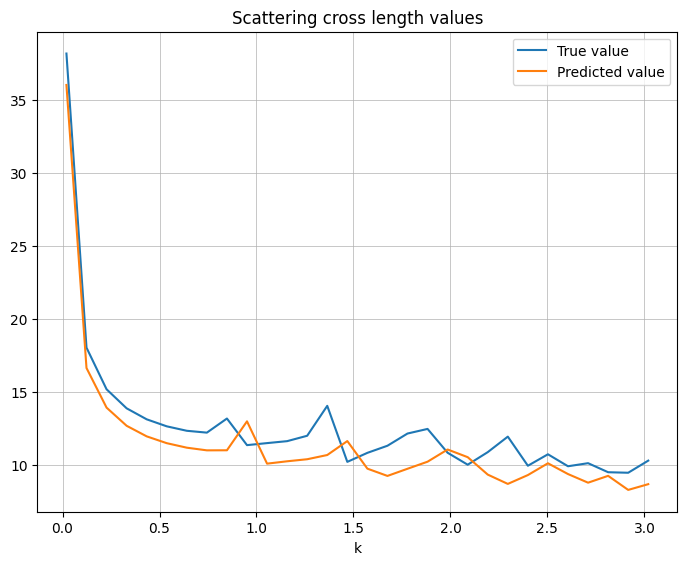

In [152]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(k, l_array, ls='-', label=f"True value")
axes.plot(k, cross_section_predicted, ls='-', label=f"Predicted value")
axes.set_title(f'Scattering cross length values')
axes.set_xlabel(f'k')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [155]:
import matplotlib

u = np.linspace(0, 2 * np.pi, 100)

x_real, y_real = 2.4 * np.cos(u), 2.4 * np.sin(u)
x_predicted, y_predicted = r * np.cos(u), r * np.sin(u)

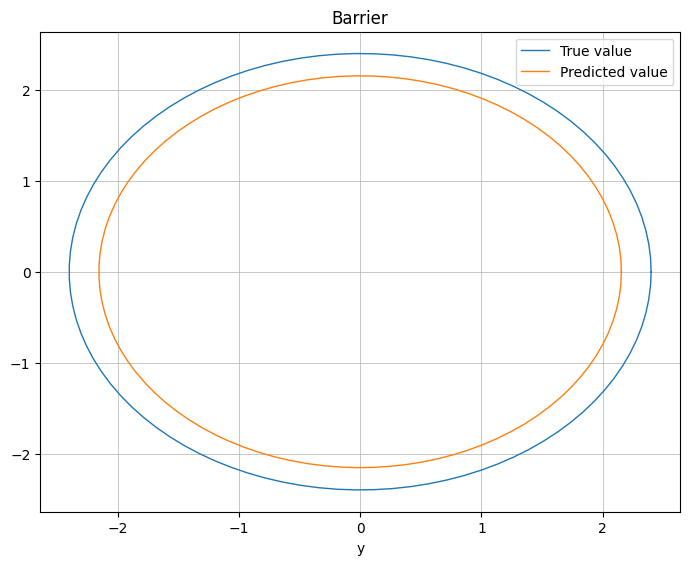

In [156]:
fig = plt.figure(figsize=(8,6))
axes = fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(x_real, y_real, ls='-', lw=1.0, label=f"True value")
axes.plot(x_predicted, y_predicted, ls='-', lw=1.0, label=f"Predicted value")
axes.set_title(f'Barrier')
axes.set_xlabel(f'x')
axes.set_xlabel(f'y')
axes.legend(loc='upper right')
plt.grid(linestyle='-', linewidth=0.5)

In [ ]:
input_size = 603
output_size = 2
rule_1 = max(input_size, output_size)
rule_2 = int(2/3 * input_size + output_size)
rule_3 = min(2 * input_size - 1, input_size + input_size // 3)
hidden_neurons = min(rule_1, rule_2, rule_3)

hidden_neurons